In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('max_rows',1000)
import os
from glob import iglob

/Users/mikesivley/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Load all structural p-values across both analyses
df = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-06-20/rsa/rsa_K_summary.txt",delimiter='\t')
df = df.drop_duplicates(["structid","chain"])

In [3]:
print "Number of structures evaluated:"
print len(df)
print "Number of variants evluated:"
print "%.0f"%np.sum(df["N"])

from qvalue import estimate
THRESH = 0.1

df.ix[~df[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(df.ix[~df[ "Kp"].isnull(), "Kp"].values)

print "\nProteins passing an FDR of %.0f%% for the unweighted analysis"%(THRESH*100)
print "Significant:   %4d"%( df['Kq']<THRESH).sum()
print "    Clustered: %4d"%((df['Kq']<THRESH) & (df["Kz"]>0)).sum()
print "    Dispersed: %4d"%((df['Kq']<THRESH) & (df["Kz"]<0)).sum()

df.ix[~df["wKp"].isnull(),"wKq"], wK_lam, wK_pi = estimate(df.ix[~df["wKp"].isnull(),"wKp"].values)

print "\nProteins passing an FDR of %.0f%% for the weighted analysis"%(THRESH*100)
print "Significant:   %4d"%( df['wKq']<THRESH).sum()
print "    Clustered: %4d"%((df['wKq']<THRESH) & (df["wKz"]>0)).sum()
print "    Dispersed: %4d"%((df['wKq']<THRESH) & (df["wKz"]<0)).sum()

Number of structures evaluated:
4569
Number of variants evluated:
984904

Proteins passing an FDR of 10% for the unweighted analysis
Significant:      2
    Clustered:    2
    Dispersed:    0

Proteins passing an FDR of 10% for the weighted analysis
Significant:   4203
    Clustered:  436
    Dispersed: 3767


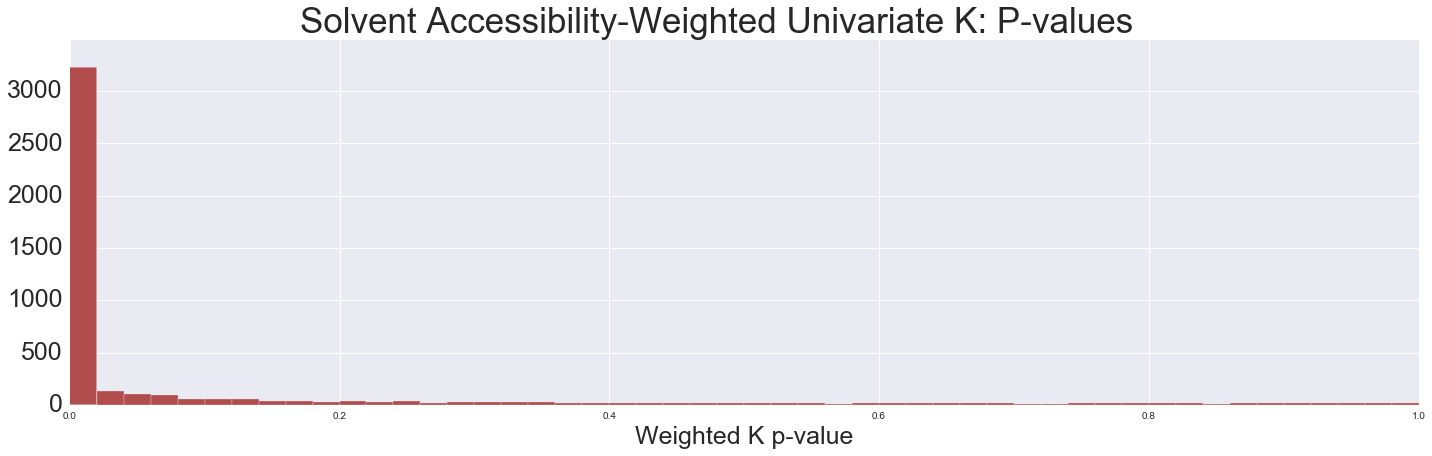

In [6]:
# P-Value Distributions
pal = list(sns.color_palette("Set1", n_colors=1, desat=.5))
fig,ax = plt.subplots(1,1,figsize=(20,6))
plt.suptitle("Solvent Accessibility-Weighted Univariate K: P-values",fontsize=35,y=1.05)
ax.set_xlabel("Weighted K p-value",fontsize=25)
ax.hist(df["wKp"],bins=np.arange(0,1.02,0.02),color=pal[0])#,normed=True)
# ax.plot(wK_lam,wK_pi,lw=3,c='black')
ax.set_yticklabels(range(0,3500,500),fontsize=25)
plt.tight_layout()
plt.show()

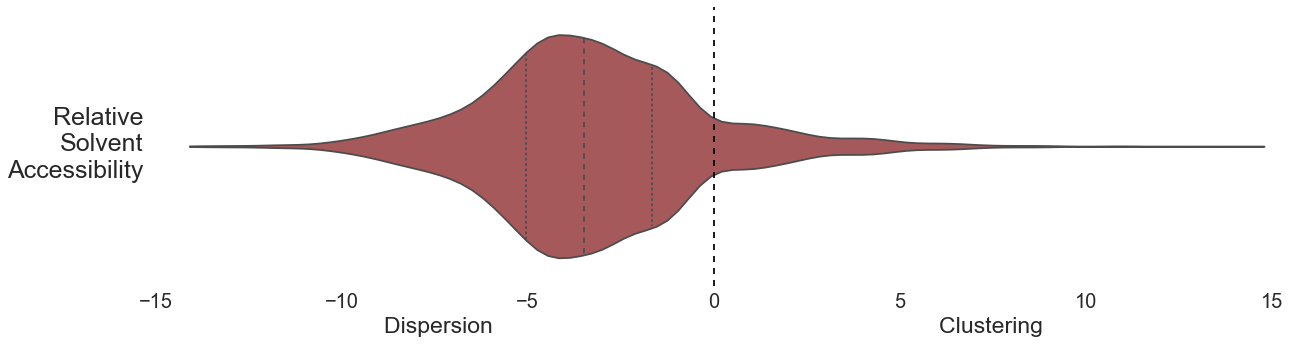

In [14]:
# Setup the plot
fig,ax = plt.subplots(figsize=(20,5),sharex=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=3, desat=.5))

# Plot the FDR-significant K for RSA-weighted residues
tdf = prep_split(df)
sns.violinplot(x='wKz',y='dummy',data=tdf,inner='quart',color=pal[0],scale='width',cut=0,ax=ax)
tdf.ix[tdf['fdr']!='FDR < 0.1','Kz'] = np.nan
# sns.stripplot(x='wKz',y='dummy',hue='fdr',data=tdf,jitter=True,linewidth=1,color=pal[0],orient='h',split=True,edgecolor='white',size=10,lw=2,ax=ax)
ax.set_ylabel("Relative\nSolvent\nAccessibility",fontsize=25,rotation='horizontal',ha='right',y=0.37)
handles, labels = ax.get_legend_handles_labels()
ax.legend(fontsize=20,handles=handles[:2])
ax.axvline(0.,ls='dashed',c='black')
plt.rcParams['xtick.labelsize'] = 20
plt.xlabel("Dispersion%sClustering%s"%(' '*70,' '*0),fontsize=23)
ax.patch.set_visible(False)
plt.show()

In [11]:
def prep_split(dfx):
    df  = dfx.copy()
    df['fdr']  = 'All              (N=%4d)'%len(df)
    dft = dfx[dfx["wKq"]<0.1].copy()
    dft['fdr'] = 'FDR < 0.1 (N=%4d)'%len(dft)
    df = pd.concat((df,dft)).dropna(subset=["wKz"])
    df['dummy'] = ''
    return df

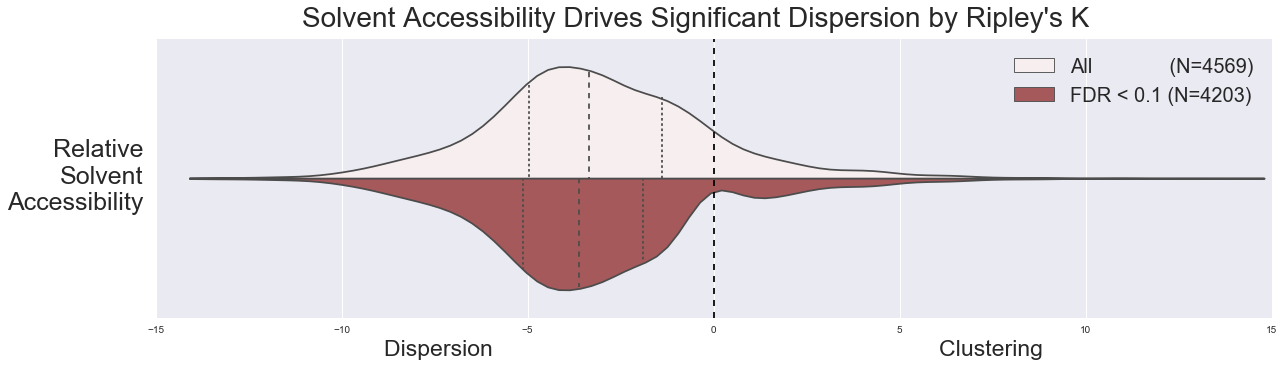

In [6]:
# Setup the plot
fig,ax = plt.subplots(figsize=(20,5),sharex=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=3, desat=.5))

# Plot the FDR-significant K for RSA-weighted residues
tdf = prep_split(df)
sns.violinplot(x='wKz',y='dummy',hue='fdr',data=tdf,inner='quart',color=pal[0],split=True,scale='width',cut=0,ax=ax)
tdf.ix[tdf['fdr']!='FDR < 0.1','Kz'] = np.nan
# sns.stripplot(x='wKz',y='dummy',hue='fdr',data=tdf,jitter=True,linewidth=1,color=pal[0],orient='h',split=True,edgecolor='white',size=10,lw=2,ax=ax)
ax.set_ylabel("Relative\nSolvent\nAccessibility",fontsize=25,rotation='horizontal',ha='right',y=0.37)
handles, labels = ax.get_legend_handles_labels()
ax.legend(fontsize=20,handles=handles[:2])
ax.axvline(0.,ls='dashed',c='black')
plt.rcParams['xtick.labelsize'] = 20
plt.xlabel("Dispersion%sClustering%s"%(' '*70,' '*0),fontsize=23)
plt.suptitle("Solvent Accessibility Drives Significant Dispersion by Ripley's K",fontsize=28,y=0.99)
plt.show()

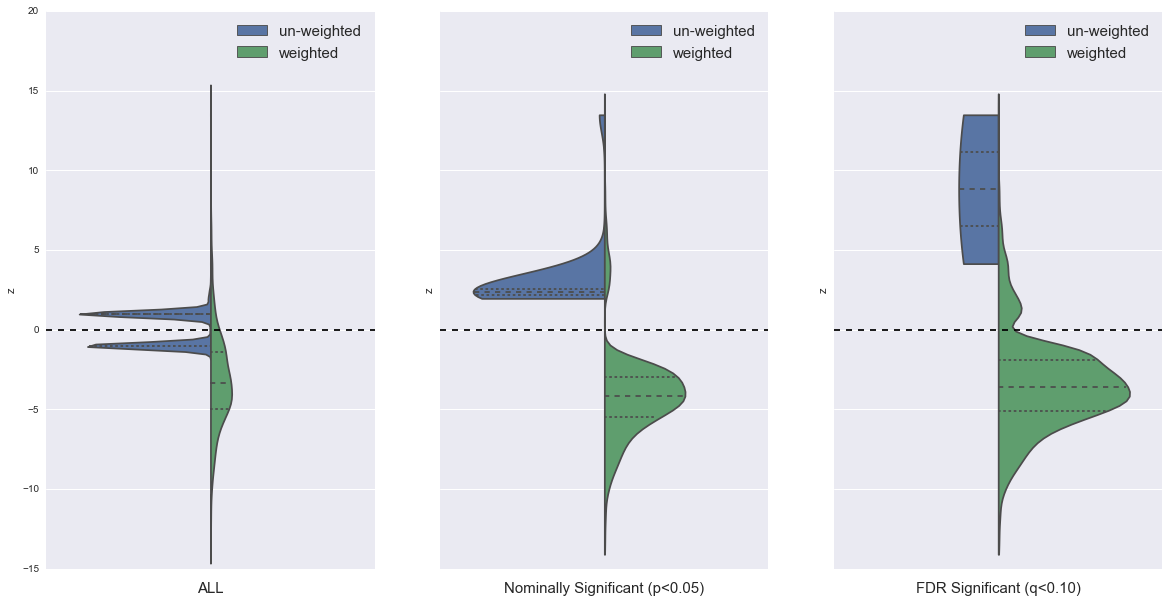

In [7]:
dfu = pd.DataFrame(df[["Kp","Kz"]].values,columns=["p","z"])
dfu['q'] = estimate(dfu["p"].values)[0]
dfu["w"] = "un-weighted"
dfw = pd.DataFrame(df[["wKp","wKz"]].values,columns=["p","z"])
dfw['w'] = "weighted"
dfw.ix[~dfw['p'].isnull(),'q'] = estimate(dfw.ix[~dfw['p'].isnull(),"p"].values)[0]
dfv = pd.concat((dfu,dfw))
dfv['dummy'] = ""

fig,ax = plt.subplots(1,3,figsize=(20,10),sharey=True)
sns.violinplot(x='dummy',y="z",hue='w',data=dfv,ax=ax[0],cut=1,orient='v',split=True,inner='quart')
dfv1 = dfv[dfv["p"]<0.05]
if not dfv1.empty:
    split = len(dfv1["w"].drop_duplicates()) > 1
#     split = (dfv1["w"]=="weighted").sum() > 0
    sns.violinplot(x='dummy',y="z",hue='w',data=dfv1,ax=ax[1],orient='v',split=split,cut=0,inner='quart')
#     sns.stripplot( x='dummy',y="z",hue='w',data=dfv1,ax=ax[1],orient='v',split=True,jitter=True,s=7,lw=1,edgecolor='white')
dfv1 = dfv[dfv["q"]<THRESH]
if not dfv1.empty:
    split = (dfv1["w"]=="weighted").sum() > 0
    sns.violinplot(x='dummy',y="z",hue='w',data=dfv1,ax=ax[2],orient='v',split=split,cut=0,inner='quart')
#     sns.stripplot( x='dummy',y="z",hue='w',data=dfv1,ax=ax[2],orient='v',split=True,jitter=True,s=7,lw=1,edgecolor='white')
ax[0].set_xlabel("ALL",fontsize=15)
ax[1].set_xlabel("Nominally Significant (p<0.05)",fontsize=15)
ax[2].set_xlabel("FDR Significant (q<%.2f)"%THRESH,fontsize=15)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)
# plt.ylim([-5,15])
ax[0].axhline(0.,ls='dashed',c='black')
ax[1].axhline(0.,ls='dashed',c='black')
ax[2].axhline(0.,ls='dashed',c='black')
plt.show()

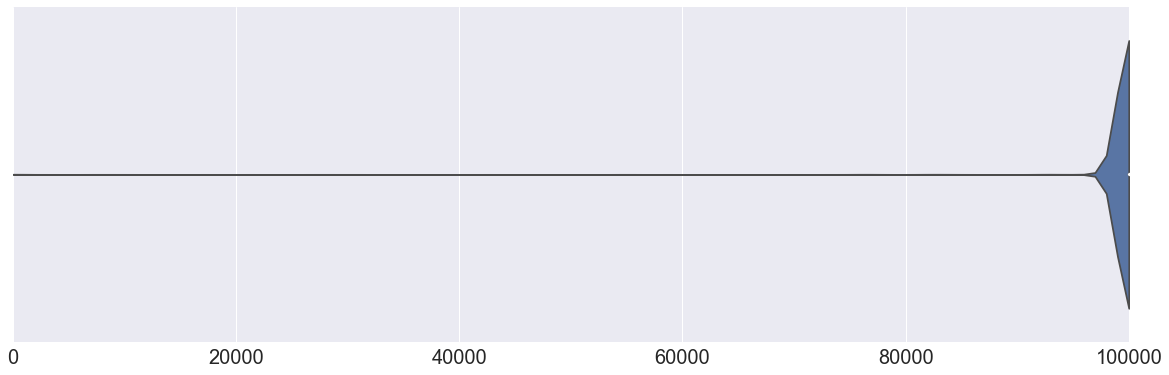

In [8]:
# Despite 100k permutations, very few structures
# observe anywhere near that many unique values
fig,ax = plt.subplots(1,1,figsize=(20,6))
plt.subplots_adjust(wspace=0, hspace=0)
sns.violinplot(df['wP'].values,cut=0,ax=ax)
ax.set_xlim([0,100000])
plt.show()

In [9]:
print "Un-Weighted: FDR-Significantly Clustered Proteins"
print df.ix[(df["Kq"]<0.1) & (df["Kz"]>0),["structid","chain","Kz","Kp","Kq"]]

Un-Weighted: FDR-Significantly Clustered Proteins
     structid chain         Kz       Kp       Kq
519      1CC0     E  13.477831  0.00002  0.04569
7376     3FCS     C   4.142324  0.00002  0.04569


In [10]:
print "Weighted: FDR-Significantly Dispersed Proteins"
print df.ix[(df["wKq"]<0.1) & (df["wKz"]<0),["structid","chain","wKz","wKp","wKq"]]

Weighted: FDR-Significantly Dispersed Proteins
     structid chain        wKz      wKp       wKq
3        1L2Z     B  -1.303589  0.15522  0.033043
5        3MHR     P  -2.183529  0.03598  0.008623
7        1I3Z     B  -0.920864  0.32254  0.064589
11       1BOR     A  -1.538854  0.10516  0.023118
12       4B6D     E  -2.353778  0.00578  0.001547
13       3LE4     A  -4.335253  0.00002  0.000008
14       2K2M     A  -1.550394  0.07608  0.017203
15       1AAP     A  -3.897756  0.00002  0.000008
16       4F14     A  -3.074291  0.00018  0.000059
19       2F60     K  -3.847844  0.00002  0.000008
22       2E5R     A  -1.055394  0.26688  0.054299
23       3NAU     A  -2.311760  0.00876  0.002276
24       1I27     A  -4.147075  0.00002  0.000008
25       3KFD     J  -2.361837  0.00558  0.001495
26       2LNB     A  -1.040761  0.20250  0.042276
29       2C5L     D  -3.088594  0.00022  0.000072
30       2HYI     D  -1.861423  0.04948  0.011557
33       1RGO     A  -1.824103  0.02922  0.007097
34 